In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

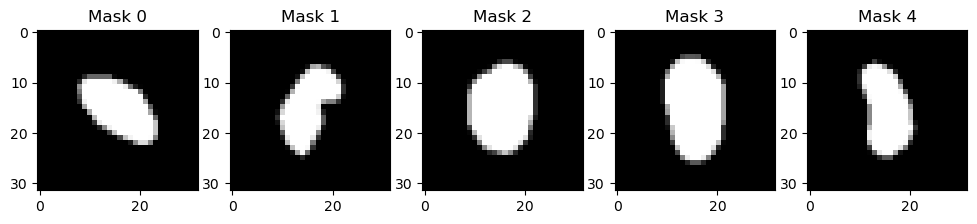

In [2]:
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)

BATCH_SIZE = 100

IMG_FOLDER = "images/bbbc039/masks/"

train_imgs, val_imgs = datasets.split_folder(IMG_FOLDER, 0.9, max_images=5000)

train_auto_dataset = datasets.CachedImages(IMG_FOLDER, train_imgs, train=True)
val_auto_dataset = datasets.CachedImages(IMG_FOLDER, val_imgs)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}", metaimage.Mask(train_auto_dataset[i][0])) for i in range(5)
        ]
    ],
    figsize=(12, 12),
)
display.show()

In [3]:
LATENT_SIZE = 128
BASE_CHANNELS = 16
DISCRIMINATOR_CHANNELS = 4
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.2
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

discriminator = torch.nn.Sequential(
    nnet.blocks.conv.BasicConvBlock(
        in_channels=1,
        out_channels=DISCRIMINATOR_CHANNELS,
        kernel_size=1,
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
        out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        layer_factory=nnet.blocks.conv.create_basic_conv_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        total_layers=1,
    ),
    nnet.blocks.conv.ConvToLinear(
        (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        out_dim=1,
        activation=torch.nn.Sigmoid,
    ),
)

voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 4), 4, 4, 4),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 4), 4, 4, 4),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
                kernel_size=5,
            ),
            layer_factories_per_downsample=1,
        ),
        nnet.blocks.resnet.create_resnet_block_simple_3d(
            in_channels=BASE_CHANNELS,
            out_channels=BASE_CHANNELS,
            activation=ACTIVATION,
            stochastic_depth_rate=GENERATOR_DROPOUT,
            kernel_size=3,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust(),
    )

mask_generator = torch.nn.Sequential(
    voxel_generator,
    nnet.modules.RandomImageFromVoxGrid(device=DEVICE),
)

gan_trainer = nnet.training.GANTrainer(
    mask_generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

In [4]:
model_path = "models/bbbc039_gan"

gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    201,
    path=model_path,
    noise=0.3,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
)

Epoch 201/201 | val loss (gen/dis): 1.2941/4.1286 | train loss: 1.58(201)/0.38(70): 100%|██████████| 201/201 [1:27:05<00:00, 26.00s/it] 


Model models/bbbc039_gan_0.pt is loaded from epoch 0 , loss 1.2826
Model models/bbbc039_gan_1.pt is loaded from epoch 10 , loss 0.8905
Model models/bbbc039_gan_2.pt is loaded from epoch 20 , loss 1.5223
Model models/bbbc039_gan_3.pt is loaded from epoch 30 , loss 0.6853
Model models/bbbc039_gan_4.pt is loaded from epoch 40 , loss 1.0481
Model models/bbbc039_gan_5.pt is loaded from epoch 50 , loss 0.6549
Model models/bbbc039_gan_6.pt is loaded from epoch 60 , loss 0.9073
Model models/bbbc039_gan_7.pt is loaded from epoch 70 , loss 1.0053
Model models/bbbc039_gan_8.pt is loaded from epoch 80 , loss 0.9052
Model models/bbbc039_gan_9.pt is loaded from epoch 90 , loss 0.9836
Model models/bbbc039_gan_10.pt is loaded from epoch 100 , loss 0.7520
Model models/bbbc039_gan_11.pt is loaded from epoch 110 , loss 0.9657
Model models/bbbc039_gan_12.pt is loaded from epoch 120 , loss 0.9644
Model models/bbbc039_gan_13.pt is loaded from epoch 130 , loss 1.3396
Model models/bbbc039_gan_14.pt is loaded 

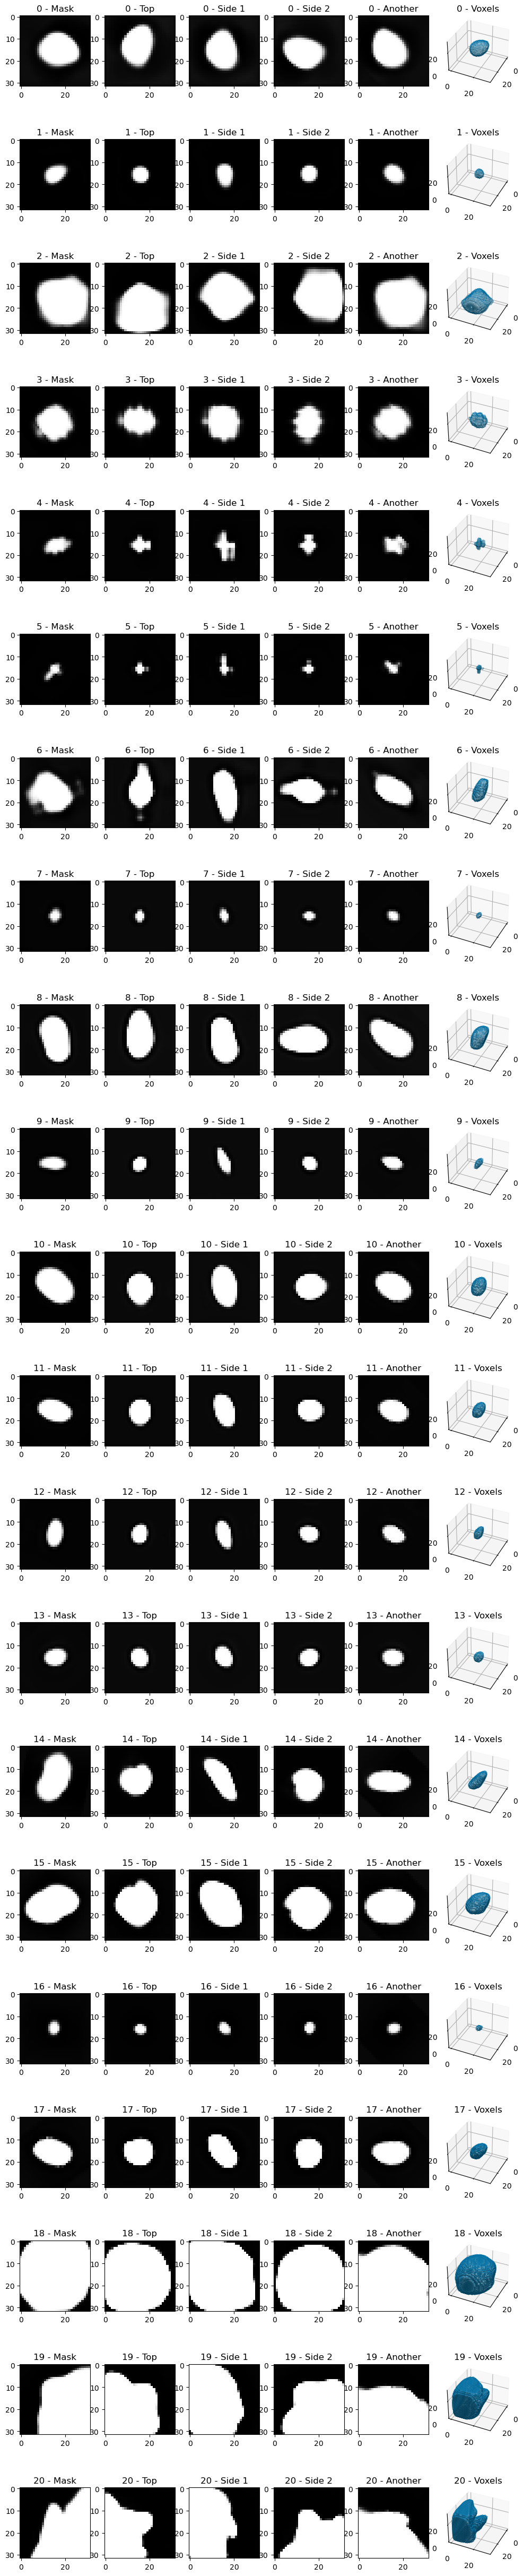

In [5]:
MODELS = (0, 20)

mask_generator.eval()
mask_generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 0.1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.Mask(
        mask_generator(gen_input)[0], title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        voxel_generator(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(x_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(np.pi / 4, np.pi / 4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/bbbc039_gan_10.pt is loaded from epoch 100 , loss 0.7520


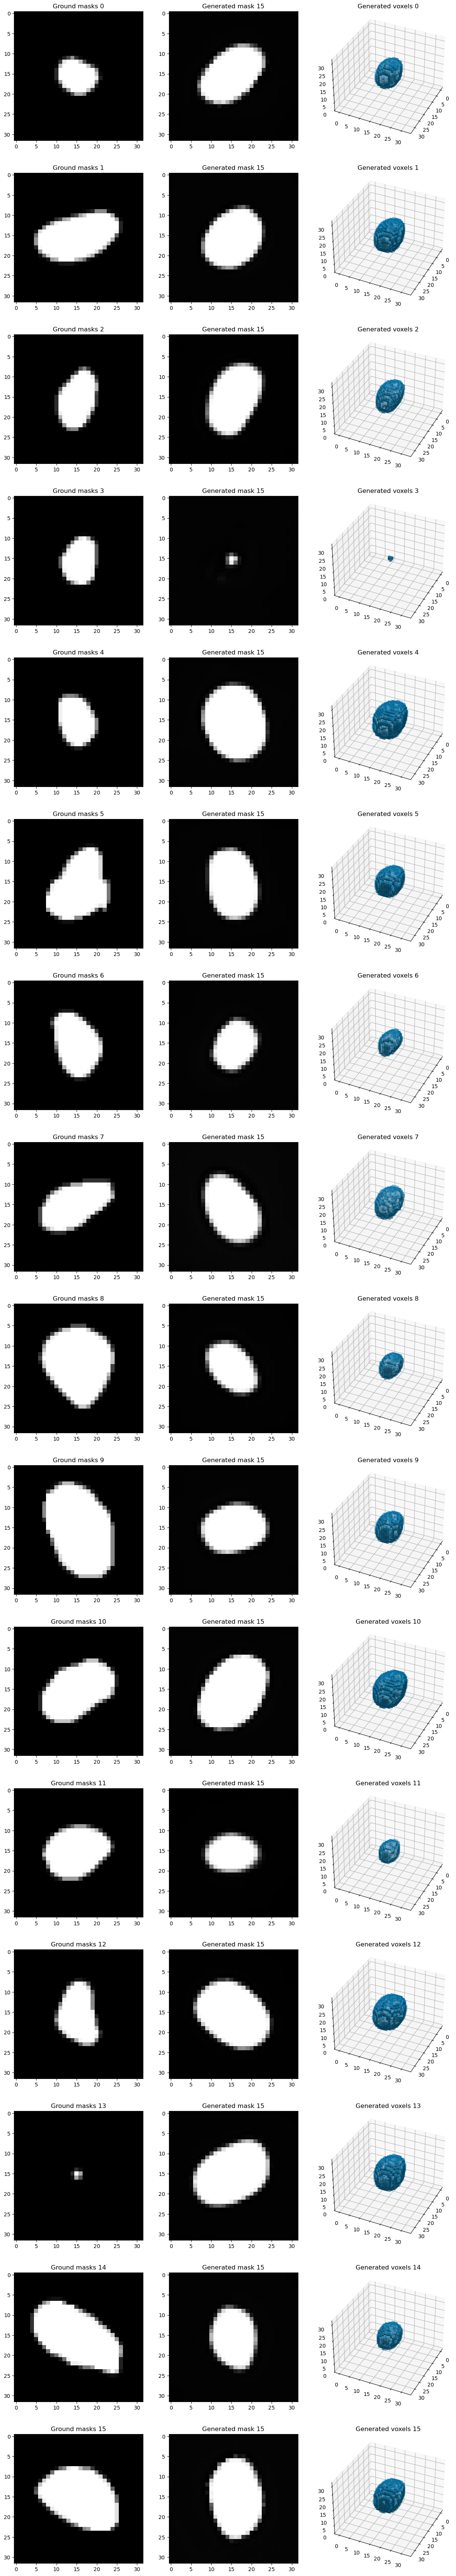

In [23]:
MODEL = 10

N_SAMPLES = 16

TRAIN_BASIS = 18

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(N_SAMPLES+1, LATENT_SIZE))).cuda()

mask_generator.train()
voxels = voxel_generator(gen_input)

voxel_grids = [voxgrid.VoxGrid(voxel, title=f"Generated voxels {i}") for i, voxel in enumerate(voxels)]

masks = [
    voxel_grid.rotated(*np.random.uniform(-np.pi, np.pi, 3)).create_image() for voxel_grid in voxel_grids
]
for mask in masks:
    mask.title = f"Generated mask {i}"

plot_grid = []

for i in range(N_SAMPLES):
    ground_mask = train_auto_dataset[i+TRAIN_BASIS][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")

    plot_grid.append([ground_mask, masks[i], voxel_grids[i]])

display.grid(plot_grid, figsize=(15, N_SAMPLES*5.5))
display.show()